In [1]:
import fvdb_3dgs
import logging
import cv2
import pathlib
import matplotlib.pyplot as plt
import numpy as np

# Let's use verbose logging to track what happens.
# For less output, set level=logging.WARN, for more set level=logging.DEBUG
logging.basicConfig(level=logging.INFO)

## Download some example data
First, let's download some example data to run on. These datasets are the output of a COLMAP SfM pipeline on a sequence of images.
They contain images, camera poses (camera to world transformations), and camera projection parameters.

In [2]:
# Download example data for running splats on
fvdb_3dgs.tools.download_example_data(dataset="all", download_path="./data")

# Manipulating Structure-from-Motion Data
The `fvdb_3dgs` library provides a number of tools for working with Structure-from-Motion (SfM) data.
The basic in-memory representation of an SfmDataset is the `fvdb_3dgs.SfmScene` class. 
Note that this class does not load all images and masks into memory since this can quickly
use up all available RAM. Instead it stores paths to images and masks, and leverages a filesystem
cache for ephemeral quantities derived from the dataset (e.g. downsampled images, or masks
computed by cropping a scene). When you load a dataset from disk, it will return both the
`SfmScene` for that dataset as well as it's cache represented as an `fvdb_3dgs.Cache` object.

An `SfmScene` consists of a few main components:
 1. `SfmScene.cameras`: Information about the camera(s) used to capture the scene. 
   - This is represented as a dictionary mapping unique integer camera IDs to `SfmCameraMetadata` objects. The `SfmCameraMetadata` class contains the camera intrinsics (projection parameters, distortion parameters, camera type, etc). *NOTE: The number of cameras is not the same as the number of images. If you used a drone with 3 mounted cameras to capture a scene, then `len(SfmScene.cameras)` will be 3.*
 2. `SfmScene.images`: Information about each captured image and its pose in the scene. 
  - This is represented as a python list of `SfmCameraMetadata` objects each of which contains the camera-to-world transform (and its inverse), the filesystem path to the image and mask (if present), the SfM correspondence points visible from this image, as well as the `SfmCameraMetada` reprenting the camera that captured this image.
 3. `SfmScene.points`/`SfmScene.points_rgb`/`SfmScene.points_err`: Information about the 3D correspondence points reconstructed 
 by the SfM algorithm. 
  - These are represented as NumPy arrays with shapes `(N,3)`/`(N,3)`/`(N,)` (where `N` is the number of points) and encode the point positions, RGB colors (as uint8 from 0 - 255), and (unnormalized) confidence scores on the accuracy of each point.
 4. `SfmScene.transformation_matrix`: 
  - A 4x4 transformation matrix represented as a NumPy array encoding a mapping from some canonical coordinate space to scene coordinates. By default, this will be the Idendity matrix, but it can change when you transform the scene (e.g. to normalize it).
 5. `SfmScene.scene_bbox`: A bounding box which is guaranteed to contain all the `SfmScene.points` points in the scene. 
  - This is represented as a NumPy array of shape `(6,)` of the form `(bmin_x, bmin_y, bmin_z, bmax_x, bmax_y, bmax_z)`. By default `bmin_x=bmin_y=bmin_z=-inf` and `bmax_x=bmax_y=bmax_z=inf` but this can change when you transform the scene (e.g. by cropping it).


INFO:load colmap:Loading visible points per image from cache...


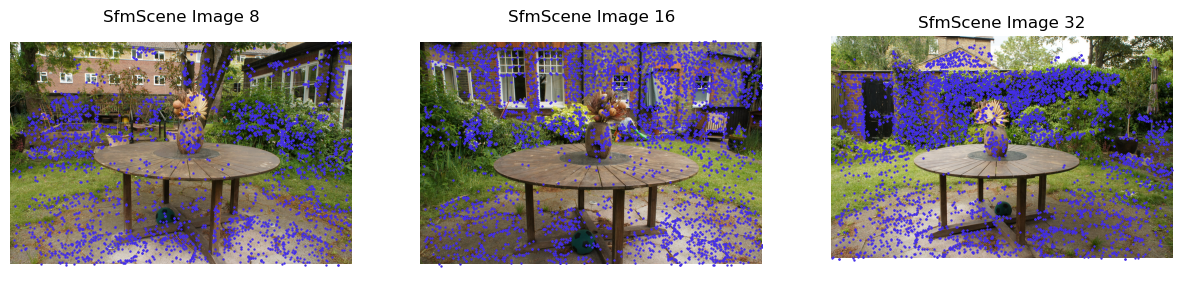

In [ ]:
dataset_path = "./data/360_v2/garden"
scene = fvdb_3dgs.io.load_colmap_scene(pathlib.Path(dataset_path))

# Visualize an image in an SfmScene and the 3D points visible from that images
# projected onto the image plane as blue dots.
def plot_image_from_scene(scene: fvdb_3dgs.sfm_scene.SfmScene, image_id: int):
    image_meta: fvdb_3dgs.sfm_scene.SfmImageMetadata = scene.images[image_id]
    camera_meta: fvdb_3dgs.sfm_scene.SfmCameraMetadata = image_meta.camera_metadata

    # Get the visible 3d points for this image
    visible_points_3d: np.ndarray = scene.points[image_meta.point_indices]

    # Project those points onto the image plane
    # 1. Get the world -> camera space transform and projection matrix
    world_to_cam_matrix: np.ndarray = image_meta.world_to_camera_matrix
    projection_matrix: np.ndarray = camera_meta.projection_matrix
    # 2. Transform world points to camera space
    visible_points_3d_cam_space = world_to_cam_matrix[:3,:3] @ visible_points_3d.T + world_to_cam_matrix[:3,3:4]
    # 3. Transform camera space coordinates to image space
    visible_points_2d = projection_matrix @ visible_points_3d_cam_space
    visible_points_2d /= visible_points_2d[2]

    # Load the image and convert to RGB (OpenCV uses BGR by default)
    loaded_image = cv2.imread(image_meta.image_path)
    assert loaded_image is not None, f"Failed to load image at {image_meta.image_path}"
    loaded_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)

    # Plot the image and projected points
    plt.title(f"SfmScene Image {image_id}")
    plt.axis("off")
    plt.imshow(loaded_image)
    plt.scatter(visible_points_2d[0], visible_points_2d[1], color="#432de9", marker=".", s=2)

# Plot three images and points alongside each other
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_image_from_scene(scene, 8)
plt.subplot(1, 3, 2)
plot_image_from_scene(scene, 16)
plt.subplot(1, 3, 3)
plot_image_from_scene(scene, 32)
plt.show()


## Optimizing a Gaussian Splat Scene from Data
The `fvdb_3dgs` module provides a set of easy-to-use tools for optimizing a Gaussian Splat scene from
data. The simplest way to get started is by creating a `SceneOptimizer` and calling train.
This will produce a trained model which can be evaluated, saved, or used for downstream tasks (like meshing).

In [ ]:
# Now that we have data, let's optimize a 3d Gaussian Splat scene on that data
# This creates a new optimizer for your dataset with default parameters which should produce
# reasonable results on the vast majority of inputs

# TODO:
#  - Set arguments to use every image in training by default
#  - In this example, use a validation set to show how to do this
#  - Viewer disabled by default, enabling it shows a nice UI in jupyter
scene_optimizer = fvdb_3dgs.training.SceneOptimizationRunner.new_run(dataset_path="./data/360_v2/garden")
scene_optimizer.train()

INFO:load colmap:Loading visible points per image from cache...
INFO:fvdb_3dgs.transforms.normalize_scene.NormalizeScene:Normalizing SfmScene with normalization type: pca
INFO:fvdb_3dgs.transforms.percentile_filter_points.PercentileFilterPoints:Filtering points based on percentiles: min=[0. 0. 0.], max=[100. 100. 100.]
INFO:fvdb_3dgs.transforms.percentile_filter_points.PercentileFilterPoints:No points will be filtered out, returning the input scene unchanged.
INFO:fvdb_3dgs.transforms.downsample_images.DownsampleImages:Rescaling images using downsample factor 4, sampling mode 3, and quality 100.
INFO:fvdb_3dgs.transforms.downsample_images.DownsampleImages:Attempting to load downsampled images from cache.
INFO:fvdb_3dgs.training.scene_optimization_runner.SceneOptimizationRunner:Created dataset training and test datasets with 183 training images and 2 test images.
INFO:fvdb_3dgs.training.scene_optimization_runner.SceneOptimizationRunner:Model initialized with 138,766 Gaussians
INFO:fvdb_

INFO:websockets.server:server listening on 0.0.0.0:8080


╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8080   │
│   Websocket │ ws://localhost:8080     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Passing ['initial_value'] as positional arguments to add_dropdown is deprecated. Please use keyword 
arguments instead: initial_value=-z

(viser) Passing ['initial_value'] as positional arguments to add_dropdown is deprecated. Please use keyword 
arguments instead: initial_value=-z

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=0.01, max=0.5, step=0.05

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=1, max=64, step=1

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=0.0, max=3.0, step=0.1

INFO:fvdb_3dgs.training.scene_optimization_runner.ViewerLogger:Using scene extent = [85.47407504 96.41918457 16.56568191] for viewer. Scaling camera view axis by 1.299111175966777.


(viser) Passing ['initial_value'] as positional arguments to add_dropdown is deprecated. Please use keyword 
arguments instead: initial_value=-z

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=0.01, max=0.5, step=0.05

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=1, max=64, step=1

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=0.0, max=3.0, step=0.1

(viser) Passing ['initial_value'] as positional arguments to add_dropdown is deprecated. Please use keyword 
arguments instead: initial_value=-z

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=0.01, max=0.5, step=0.05

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=1, max=64, step=1

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=0.0, max=3.0, step=0.1

(viser) Passing ['initial_value'] as positional arguments to add_dropdown is deprecated. Please use keyword 
arguments instead: initial_value=-z

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=0.01, max=0.5, step=0.05

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=1, max=64, step=1

(viser) Passing ['min', 'max', 'step'] as positional arguments to add_number is deprecated. Please use keyword 
arguments instead: min=0.0, max=3.0, step=0.1

loss=0.086| sh degree=3| num gaussians=1,426,170:   9%|▉         | 3364/36600 [00:43<10:04, 55.02imgs/s]